# Point Robot Roadmap Graph

Generate a roadmap graph for a point robot and save it to a csv file.

In [1]:
import numpy as np
import pandas as pd
import math
import time

import scipy.spatial as spatial
import matplotlib.pyplot as plt

In [2]:
# define parameters
# X_DIM = 10 # environment x dimension in meters
# Y_DIM = 10 # environment y dimension in meters
X_MIN = -10 # environment x dimension minimum
X_MAX = 10 # environment x dimension maximum
Y_MIN = -10 # environment y dimension minimum
Y_MAX = 10 # environment y dimension maximum
NEIGHBORHOOD_DIST = 1 # neighbors nodes maximum distance 
CONFIG_COUNT = 5000

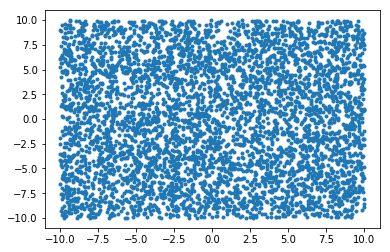

In [3]:
# Generate random configurations between min and max of each dimension
config_x = np.round(X_MIN + (X_MAX-X_MIN)*np.random.rand(CONFIG_COUNT),2) # random x-coord of config. round to 2 decimal places
config_y = np.round(Y_MIN + (Y_MAX-Y_MIN)*np.random.rand(CONFIG_COUNT),2) # random y-coord of config. round to 2 decimal places
plt.plot(config_x,config_y,'.')

In [4]:
# helping functions

# generate n obstacles with min and max rad
def generate_obstacles(n=1,rad_min=0.2,rad_max=0.5):
    radius = np.round(rad_min + (rad_max-rad_min)*np.random.rand(n),2) # generate n radius between rad_min and rad_max
    pos_x = np.round(X_MIN + (X_MAX-X_MIN)*np.random.rand(n),2) # generate x positon of n obstacles
    pos_y = np.round(Y_MIN + (Y_MAX-Y_MIN)*np.random.rand(n),2) # generate y positon of n obstacles
    return {'radius':radius,'pos_x':pos_x,'pos_y':pos_y}
#     return pd.DataFrame(np.array([pos_x,pos_y,radius]).T,columns=['center_x','center_y','radius'])

In [5]:
# generate obstacles
obstacles = generate_obstacles(13,0.5,1)

In [6]:
obstacles

{'pos_x': array([ 5.23,  4.95, -0.76, -2.78, -5.85,  0.45,  7.34, -6.84, -9.95,
         9.71, -0.01, -3.73, -0.43]),
 'pos_y': array([ 9.5 , -8.3 ,  0.05,  3.16, -4.94,  3.14, -1.33, -1.68,  7.79,
         1.48,  9.01,  0.01,  9.46]),
 'radius': array([0.84, 0.94, 0.85, 0.5 , 0.54, 0.96, 0.84, 0.9 , 0.93, 0.78, 0.84,
        0.84, 0.6 ])}

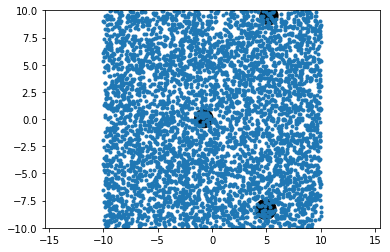

In [7]:
# plot configs and obstacles
fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
ax.plot(config_x,config_y,'.')
for i in range(len(obstacles)):
    obs = plt.Circle((obstacles['pos_x'][i],obstacles['pos_y'][i]),obstacles['radius'][i],color='k')
#     obs = plt.Circle((0,0),0.2,color='k')
    ax.add_artist(obs)
#Use adjustable='box-forced' to make the plot area square-shaped as well.
ax.set_aspect('equal', adjustable='datalim')
ax.plot()   #Causes an autoscale update.
plt.xlim(X_MIN,X_MAX)
plt.ylim(Y_MIN,Y_MAX)
plt.show()


## Obstacles to Points Distance

In [69]:
# distance of config from each obstacle
obs_dist = np.zeros([CONFIG_COUNT,len(obstacles)])
for i in range(len(obstacles)):
    obs_dist[:,i] = np.sqrt((config_x-obstacles['pos_x'][i])**2+(config_y-obstacles['pos_y'][i])**2)
    
# minimum distance and its index of each config from obstacle
dist_obs_min = np.min(obs_dist,axis=1)
idx_min_obs_dist = np.argmin(obs_dist,axis=1)

## Validate Configs

Find valid and invalid configs

In [14]:
# distance between two points
def dist_bw_points(p1,p2):
    dist = math.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)
    return dist

# check whether a point is inside circle or not    
def collision_bw_point_and_circle(point,idx):
    dist = dist_bw_points(point,[obstacles['pos_x'][idx],obstacles['pos_y'][idx]])
    if dist < obstacles['radius'][idx]:
        return False, dist
    else:
        return True, dist
# function to check whether a config is valid or not
def validate_configuration(conf):
    obs_dist = 1000*np.ones(len(obstacles))
    for i in range(len(obstacles)):
        is_valid, dist = collision_bw_point_and_circle(conf,i)
        obs_dist[i] = dist
        if not is_valid:
            return 0, dist
    dist_min = np.min(obs_dist)
    return 1, dist_min
    

In [15]:
# # create a pandas frame of configs
# configs = pd.DataFrame(np.array([config_x,config_y]).T,columns=['x','y'])
# configs['valid'] = 1 # initialize all configs to be valid
# configs.head()

In [16]:
# check validity of configs
config_valid = np.ones(CONFIG_COUNT)
config_obs_dist = np.zeros(CONFIG_COUNT)
start = time.time()
for j in range(CONFIG_COUNT):
    config_valid[j],config_obs_dist[j] = validate_configuration([config_x[j],config_y[j]])
done = time.time()
elapsed = done - start
print(elapsed)


0.07850050926208496


## Generate Graph and find Neighbors

In [32]:
configs = np.array([config_x,config_y]).T
tree = spatial.cKDTree(configs)


In [34]:
neighbors = tree.query_ball_point([1.5, 2.5], 1)
print(neighbors)

[4370, 1634, 2291, 2102, 2153, 4715, 3062, 1180, 3665, 476, 941, 1458, 4010, 4, 2319, 272, 1391, 3359, 198, 580, 1239, 2797, 3668, 2466, 3767, 2315, 4801, 4687, 4409, 1112, 1280, 2135, 1618, 55, 2642, 586]


In [17]:
# separate valid and invalid configs
invalid_configs = np.where(config_valid == 0.0)
invalid_configs = invalid_configs[0]
valid_configs = np.where(config_valid == 1.0)
valid_configs = valid_configs[0]
print('Valid',len(valid_configs),'Invalid',len(invalid_configs))

Valid 4896 Invalid 104


In [43]:

# find distance between a point p and a line using two end points pa and pb
def dist_bw_point_and_line(p,pa,pb):
    ab = pb - pa
    ap = p - pa
    ap_proj = np.dot(ap,ab)/np.linalg.norm(ab)#float ap_proj = ap.dot(ab)/(ab.norm());
    ap_dist = math.sqrt(np.sum(ap**2))# 		Eigen::Vector3f ap_sqr = ap.cwiseProduct(ap);
# 		float ap_dist = std::sqrt(ap_sqr.sum());
    dist = math.sqrt(ap_dist**2-ap_proj**2)# 		float dist = std::sqrt(ap_dist*ap_dist - ap_proj*ap_proj);
    return dist


In [51]:
a = np.array([5,6])
b = np.array([15,6])
p = np.array([3,3])
print(np.sqrt(a))
print(dist_bw_point_and_line(p,a,b))

[2.23606798 2.44948974]
2.9999999999999996


In [55]:
# find line parameters from points
def line_from_points(p1,p2):
    a = -(p2[1]-p1[1])
    b = p2[0]-p1[0]
    c = -a*p1[0]-b*p1[1]
    return a,b,c

In [57]:
a = np.array([15,16])
b = np.array([15,6])
p = np.array([3,3])
print(np.sqrt(a))
print(line_from_points(a,b))

[3.87298335 4.        ]
(10, 0, -150)


In [ ]:
# validate neighbors by checkig that path from current config to neighbor does not intersect an obstacle
# Psuedocode
# for each config
#     find neighbors
#     for each neighbor
#         check that it is valid
#         if di
# check that distance to nearest 
def validate_adjacency(conf, neighbor_ids):
    neighbor_status = np.ones(len(neighbor_ids)) # store accessibility of neighbor 1 mean yes and 0 means no
    for j in range(len(neighbor_ids)): # if neighbor is invalid, status becomes 0 and skip rest
        if (config_valid[neighbor_ids[j]] == 0.0):
            neighbor_status[j] = 0.0
        else
        

In [59]:
# create adjacency matrix
adjacency_matrix = np.zeros([CONFIG_COUNT,CONFIG_COUNT])
for i in range(len(valid_configs)):
    idx = valid_configs[i]
    cur_config = [config_x[idx], config_y[idx]]
    # get neighbors
    neighbors = tree.query_ball_point(cur_config, NEIGHBORHOOD_DIST)
    # validate sub configs
    neighbors_validity_status = validate_adjacency(cur_config,neighbors)
    adjacency_matrix[idx,neighbors] = neighbors_validity_status

In [61]:
adjacency_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [72]:
idx = np.where(adjacency_matrix==1)
adjacency_list = np.array([idx[0],idx[1]]).T

In [73]:
adjacency_list

array([[   0,    0],
       [   0,  167],
       [   0,  328],
       ...,
       [4999, 4877],
       [4999, 4987],
       [4999, 4999]])

## Log Data

In [ ]:
# log configs


In [ ]:
#log adjacency list